# TP 2: Aymane El Firdoussi: SD-TSIA204 Linear Models

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
import itertools
import warnings
from sklearn.exceptions import ConvergenceWarning
from scipy.stats import norm
from scipy.stats import t
# imports go here

In [2]:
fn1 = "Aymane"
ln1 = "El Firdoussi"
filename = "_".join(map(lambda s: s.strip().lower(),
                      ["SD-TSIA204_lab2", ln1, fn1])) + ".ipynb"
print(filename)

sd-tsia204_lab2_el firdoussi_aymane.ipynb


## Question 1: Preprocessing the data

### 1 - (a) Fixing the random seed to 0

In [17]:
# Setting the random seed to 0
np.random.seed(0)
random.seed(0)

Using this, we are now sure that we will get the same results whenever we run the code.

### 1 - (b) Loading the data and printing means and standard deviations

In [18]:
# Loading the data:
data = pd.read_csv("meatspec.csv")

#printing the mean of each covariate
data.mean()

V1       2.808561
V2       2.811137
V3       2.813727
V4       2.816363
V5       2.819098
          ...    
V97      3.081070
V98      3.062290
V99      3.043548
V100     3.024895
fat     18.142326
Length: 101, dtype: float64

In [19]:
# Printing the standard deviation of each covariate:
data.std()

V1       0.410793
V2       0.413352
V3       0.415906
V4       0.418465
V5       0.421040
          ...    
V97      0.539730
V98      0.538586
V99      0.537108
V100     0.535354
fat     12.740297
Length: 101, dtype: float64

### Interpretation:
The data is not centered since the mean is different from the null vector 0, nor it is standardized since standard deviations are not all equal to 1. 

Furthermore our data is not normalized since the values are not between 0 and 1. 

## 1 - (c) Separating the data into training and test sets 

In [20]:
# Using train_test_split to split data into training and test sets
X = data.drop(['fat'], axis=1)
y= data['fat']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)


In [21]:
# Using Standard Scaler to standardize data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
y_train_scaled = scaler.fit_transform(y_train.to_numpy().reshape(-1,1))
y_test_scaled = scaler.transform(y_test.to_numpy().reshape(-1,1))


### Let us test now whether our data is well standardized or not

In [22]:
# We print the standard deviation of X_train_scaled which sould be equal to 1
X_train_scaled.std()


1.0

## 1-d) Fitting a regular OLS:
The regular OLS is given by: 
$$ \theta = (X^TX)^{-1}X^T Y$$
We can also use the Linear Regression model from the sklean.linear_model library.

#### We don't need to fit the intercept since we centered the data.

In [23]:
# Computing the regular OLS estimator:
model = LinearRegression(fit_intercept=False)

# We fit the model to the training set
reg = model.fit(X_train_scaled,y_train_scaled)

# Prediction phase (test phase)
y_pred = reg.predict(X_test_scaled)
y_pred.shape

(54, 1)

#### 1-e) Computing the $R^2$ coefficients :
The $R^2$ can be obtained using the expression:
 $$ R^2 = 1 - \frac{\| \hat{Y} - Y \|^2}{\| Y - \bar{y}_n \mathbb{1}_n\|^2} $$

 Where $ \hat{Y} $ is the predicted vector using our model, and $\mathbb{1}_n$ is the mean of the test vector y_test_scaled.

It can also be obtained using the function r2_score from sklearn.metrics

In [24]:
# Computing the R^2 coefficient for this OLS
def R2_coef(y, y_pred):
    Y_bar = np.mean(y)
    SSR = np.sum((y_pred - y) ** 2)
    SST = np.sum((y - Y_bar) ** 2)
    return 1 - SSR / SST

# Here we use the R2 given by the sklearn library
R2 = r2_score(y_test_scaled, y_pred)

# Storing it into a dataframe
d = {'model': ['OLS'], 'R2': [R2]}
df_coef = pd.DataFrame(data=d)
df_coef

,model,R2
0,OLS,0.960055


### Interpretation :
This $R^2$ value is close to 1, then we can conclude that this model is a good fit for the data: $\hat{Y}$ is close to Y with respect to the Euclidean distance.



## Question 2: Forward variable selection

The Forward variables selection is a stepwise procedure that aims at selecting the most important and meaningful features in a dataset.
The critereon used to compare the importance of each variable is the test statistic of no effect computed within each submodel :

 $$ \hat{T}_{n,k} = \frac{| \hat{\theta}_{n,k} |}{\sqrt{\hat{G}(X_k)^{-1}_{1,1}} \hat{\sigma_n}} $$
Where $$ \hat{\theta}_n(Y,X_k) = \arg \min_{(\theta_0, \theta_1) \in \mathbb{R}^2} \| Y - \theta_0 \mathbb{1}_n - \theta_1 X_k\|^2 $$
And $$ \hat{\sigma_n} = \frac{1}{n - 2} \| Y - (\mathbb{1}_n, X_k) \hat{\theta}_n \|^2 $$
And $$ \hat{G}(X_k) = (\mathbb{1}_n, X_k)^T (\mathbb{1}_n, X_k) $$

The assoiated p-value for each test is : 
$$  p = 2(1 - \Phi(\hat{T}_{n,k}))$$
Where $\Phi$ is the cumulative distribution function of the normal distribution $\mathcal{N}(0,1)$.

In [29]:
# Define the statistic
def T(Y,X,k,n): # Y is a column vector, whereas X is our matrix
    
    # We take the k-th column of X, which is the k-th feature
    Xk_int = X[:,k].reshape(-1,1)
    Xk = np.hstack((np.ones(Xk_int.shape),Xk_int))
    
    # We compute the argmin in the expression by fitting a Linear Regression model
    reg = LinearRegression().fit(Xk,Y)
    teta_n = reg.coef_[0,1]
    
    # inverse of Gram matrix
    G_1 = np.linalg.inv(Xk.T @ Xk)
    s_n = np.sqrt(G_1[0,0])
    sigma_n = (1/(n-2)) * np.linalg.norm(Y - reg.predict(Xk), 2)**2
    return teta_n / (s_n * sigma_n)


In [38]:
# Forward variable selection algorithm
def forward_var_selection(X,Y): # X is a matrix, Y column vector and A the set of all columns of X
    n = X.shape[0]
    p = X.shape[1]
    r = Y.copy() 
    S = {} # the set of ordered features that we will get at the end, here it is a dictionary
    p_values = [] # the list of p-values

    #define the set of features
    A = list(range(0, p))

    while len(A) > 0 : 
        # Computing tests for all features
        values = np.zeros(p)
       
        for i in A : # columns left in A
            values[i] = abs(T(r, X, i, n))
        
        k_max = np.argmax(values)
        # computing the p-value associated with the value max
        p_value = 2*(1 - norm.cdf(values[k_max]))
        p_values.append(p_value)

        # Adding the feature the maximizes the test T to S
        X_max = X[:, k_max].reshape(-1, 1)
        reg = LinearRegression().fit(X_max, r)
        S[k_max] = values[k_max]
        
        # updating r
        r = r - reg.predict(X_max)
        del A[A.index(k_max)]
    
    return S, p_values
  

In [42]:
# Preparing the data to use in forward variable selection
S,p_values = forward_var_selection(X_train_scaled,y_train_scaled) # 40, 7, 39, 6

# Now since features of our dataset are written as V'number +1', then we do the following
def features(l):
    V = []
    for i in l:
        V.append('V' + str(i + 1))
    return V 

# DataFrame with features and p values
d = {'index':S.keys(), 'feature': features(S.keys()), 'p_value': p_values}
df_var_sel = pd.DataFrame(data=d).set_index('index')
df_var_sel.head(7)

,feature,p_value
index,,
40,V41,0.000000
7,V8,0.017611
39,V40,0.017450
6,V7,0.016550
41,V42,0.017183
8,V9,0.016475
38,V39,0.017288


### Comment on results:
Now we have a DataFrame containing the most important features ordered by their importance. For example, this algorithm showed us that the feature V41 is the most meaningful and important feature in our dataset. And using the p-value as a stopping criterion, we can now select the k most important features to fit an OLS on for any k.
This will be done in the next question.

## Question 3

### 3 - (a) Applying the OLS to features that have p value smaller than 0.05

In [43]:
# Selecting features with p value smaller than 0.05
mask = (df_var_sel['p_value'] < 0.05)
selected = df_var_sel.loc[mask].index.to_list()
print(selected)

[40, 7, 39, 6, 41, 8, 38, 5, 42, 9, 37, 4, 36, 10, 97, 3, 43, 11, 35, 2, 96, 12, 98]


In [44]:
# Applying OLS
reg = LinearRegression().fit(X_train_scaled[:,selected], y_train_scaled)
y_pred2 = reg.predict(X_test_scaled[:,selected])

### 3 - (b) Computing the $R^2$ coefficient for this model  

In [45]:
# R2 coefficient using sklearn
R2 = r2_score(y_test_scaled, y_pred2)
df_coef.loc[1] = ['For_Var_Sel',R2]

In [46]:
df_coef

,model,R2
0,OLS,0.960055
1,For_Var_Sel,0.955180


### Interpretation of the $R^2$ value obtained
The $R^2$ value obtained by fitting a Linear Regression model on the dataset reduced to its most important features is close to 1, then this method gives us a good prediction for our data.

## Question 4: Sequential Feature Selector

In [53]:
# Using the sequential feature selctor from sklearn.feature_selection
reg = LinearRegression()
sfs = SequentialFeatureSelector(reg, n_features_to_select = len(selected), direction = 'forward')
sfs.fit(X_train_scaled, y_train_scaled)

# Returning the selected features
selected_sfs = [i for i, x in enumerate(sfs.get_support()) if x == True]
print(selected_sfs)

[0, 1, 3, 7, 14, 18, 19, 21, 34, 39, 40, 44, 45, 46, 47, 48, 49, 57, 74, 87, 90, 97, 99]


### Observation:
We observe that the features selected by the SequentialFeatureSelector are not all the same as the ones chosen with the Forward Variable Selection algorithm. Which was expected since the stopping criterion is different in both methods. 
In fact, for the Forward Variable selection, the stopping criterion that we chose is the p value of the statistical test, which is not so accurate since we are using an asymptotical behaviour of the test, hence we probably need more data to be more accurate. Whereas the SequentialFeatureSelector compares the score for each possible feature addition or removal (accuracy, precision, etc.), and selects the one that results in the best improvement of the score.

### Computing the $R^2$ score for this new feature selection

In [56]:
# Applying OLS of new features
reg = LinearRegression().fit(X_train_scaled[:,selected_sfs], y_train_scaled)
y_pred3 = reg.predict(X_test_scaled[:,selected_sfs])

# R2 coefficient using sklearn
R2 = r2_score(y_test_scaled, y_pred3)

# Adding the new value to the dataFrame df_coef
df_coef.loc[2] = ['Seq_Feat_Sel',R2]

In [57]:
df_coef

,model,R2
0,OLS,0.960055
1,For_Var_Sel,0.955180
2,Seq_Feat_Sel,0.942024


## Observation
We observe that the $R^2$ score for both methods remain close to each other. Hence, we can use any of these methods for our prediction task.
It is even a surprising to observe that the $R^2$ score obtained with Forard Variable Selection is a little higher than the one obtained with the Sequential Feature selector, since this last one aims at maximizing the score.

## Ridge

## Question 5

The Ridge estimator is the solution of the following optimization problem:
$$ \hat{\theta}_n = \arg \min_{\theta \in \mathbb{R}^p} \| Y - X\theta\|^2 + \alpha \| \theta \|^2 $$
The function to minimize is $ \alpha $-strongly convex, hence the solution to this problem is unique and is given by:
$$ \hat{\theta}_n = (X^T X + \alpha I_p)^{-1} X^T Y$$
Where $X \in \mathbb{R}^{n x p}$ and $ Y \in \mathbb{R}^n $

In [58]:
# Programming the ridge estimator
def Ridge(X,Y,alpha):
    p = X.shape[1]
    return np.linalg.inv( X.T @ X + alpha* np.eye(p)) @ X.T @ Y

### 5 - (a)

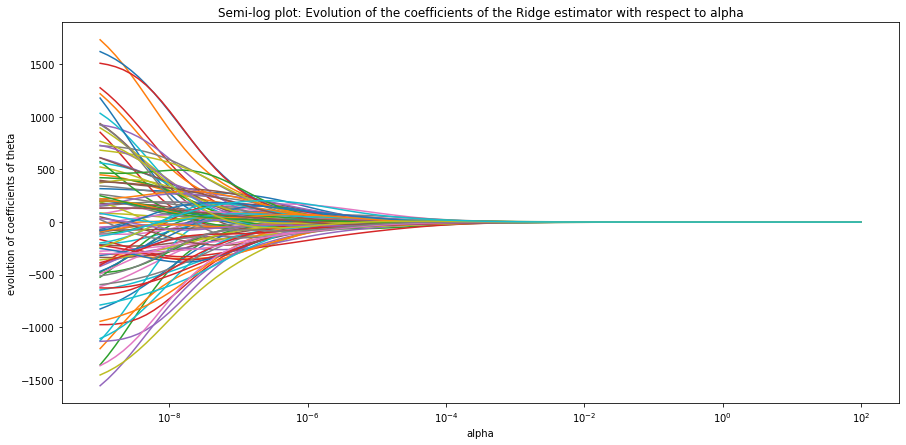

In [59]:
# Set of values of alpha
alpha_interval = np.logspace(np.log10(1e-9), np.log10(100), num=100)

# Computing the ridge estimators for each alpha and storing results in a list called estimators
estimators = Ridge(X_train_scaled, y_train_scaled, alpha_interval[0])

for alpha in alpha_interval[1:]:
    estimators = np.hstack((estimators,Ridge(X_train_scaled, y_train_scaled, alpha)))

# Plotting the evolution
plt.figure(figsize=(15,7))
for i in range(len(estimators)):
    plt.semilogx(alpha_interval, estimators[i])
plt.xlabel("alpha")
plt.ylabel("evolution of coefficients of theta")
plt.title("Semi-log plot: Evolution of the coefficients of the Ridge estimator with respect to alpha")
plt.show()

### Interpretation of the figure:
We observe that the Ridge estimator goes to zero when $\alpha$ is high. Which was expected since if $\alpha$ becomes large enough, we have that $\forall \theta \in \mathbb{R}^p$ : $$ \alpha \| \theta \|^2 + \| Y - X\theta \|^2 \geq  \| Y \|^2 $$ 
Hence, in that case: 0 is the unique solution to the problem.


### 5 - (b) Computing the Mean Squared Errors for train and test sets

In [60]:
# Define the Mean Squared Error (MSE)
def MSE(y,y_pred):
    n = len(y)
    return np.sum( (y - y_pred)**2 ) / n

# MSE of training set and test set
MSE_train = []
MSE_test = []
for i in range(estimators.shape[1]):
    # Computing the predictions
    y_pred_train = X_train_scaled @ estimators[:,i].reshape(-1,1)
    y_pred_test = X_test_scaled @ estimators[:,i].reshape(-1,1)
    
    # Adding predictions to the lists
    MSE_train.append( MSE(y_train_scaled, y_pred_train) )
    MSE_test.append(MSE(y_test_scaled, y_pred_test))

argmin_train = np.argmin(MSE_train)
argmin_test = np.argmin(MSE_test)
min_train = min(MSE_train)
min_test = min(MSE_test)

#### Plotting the evolution of the Mean Squared Errors

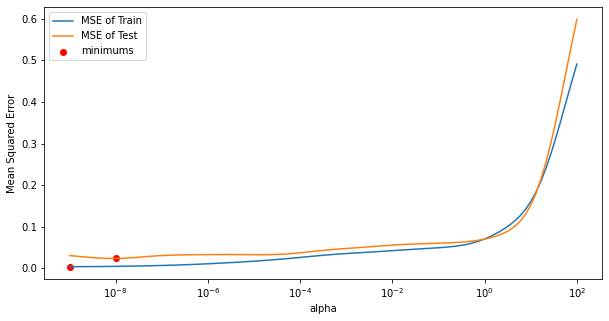

In [61]:
# Plotting the evolution of MSE
plt.figure(figsize = (10,5))
plt.semilogx(alpha_interval, MSE_train, label = 'MSE of Train')
plt.semilogx(alpha_interval, MSE_test, label = 'MSE of Test')
plt.scatter(alpha_interval[[argmin_train, argmin_test]], [min_train, min_test], c='r', label = 'minimums')
plt.xlabel("alpha")
plt.ylabel("Mean Squared Error")
plt.legend()
plt.show()

### Observation:
We conclude that both the Mean squared errors increase, and the rate of growth is small for $ \alpha \in [10^{-9}, 1]$ and high for $ \alpha \in [1, 10^{2}]$, whihc is again expected since the coefficients of the estimator go to 0 when $\alpha$ is large. 

### 5 - (c) Storing the $R^2$ score for the best performing $\alpha$

In [62]:
# The best alpha is the following
best_alpha = alpha_interval[argmin_train]

# Computing the R2 coefficient using the function that we defined in question 1
y_pred4 = X_test_scaled @ estimators[:,argmin_train].reshape(-1,1)
r2 = R2_coef(y_test_scaled, y_pred4)
print(r2)
# Adding this new coefficient to the Dataframe
df_coef.loc[3] = ['Ridge',r2]
df_coef

0.9692234532573206


,model,R2
0,OLS,0.960055
1,For_Var_Sel,0.955180
2,Seq_Feat_Sel,0.942024
3,Ridge,0.969223


### Remark :
We observe that the Ridge model describes well our data, since it has the highest $R^2$ score among all past models.

## Cross-validation, Lasso and Elastic Net

## Question 6

### 6 - (a) Lasso model: estimated waiting time: 1min and 15 seconds

In [85]:
# Interval of values of alpha in our Lasso model
L_alpha_interval = np.logspace(np.log10(1e-5), np.log10(1e-2), num=100)

# Creating two lists that will contain the predictions associated to each Lasso model
L_pred_train = []
L_pred_test = []

# Computing the Lasso estimator for each alpha and storing results in a list called L_estimators
lasso = Lasso(alpha = L_alpha_interval[0], tol = 1e-2, max_iter = 500000)
lasso.fit(X_train_scaled, y_train_scaled)
L_estimators = lasso.coef_.reshape(-1,1)
L_pred_train.append(lasso.predict(X_train_scaled))
L_pred_test.append(lasso.predict(X_test_scaled))

for alpha in L_alpha_interval[1:]:
    lasso = Lasso(alpha, tol = 1e-2, max_iter = 500000)
    lasso.fit(X_train_scaled, y_train_scaled)
    L_estimators = np.hstack((L_estimators,lasso.coef_.reshape(-1,1)))
    
    # Predictions
    L_pred_train.append(lasso.predict(X_train_scaled))
    L_pred_test.append(lasso.predict(X_test_scaled))


### Interpretation on warnings

Since the Lasso algorithm performs a descent algorithm on the function:
$$ \label{LASSO} \tag{LASSO} \theta \longrightarrow \| Y - X\theta\|^2 + \alpha \| \theta\|_1 $$ 
Because this equation does not have a unique solution, then we need to satisfy a compromise between tol, the precision, and max_iter, the maximum number of iterations of the algorithm n order to obtain a satisfying solution.

### 6 - (b) Plotting the evolution of coefficients with $\alpha$

In [86]:
L_estimators.shape

(100, 100)

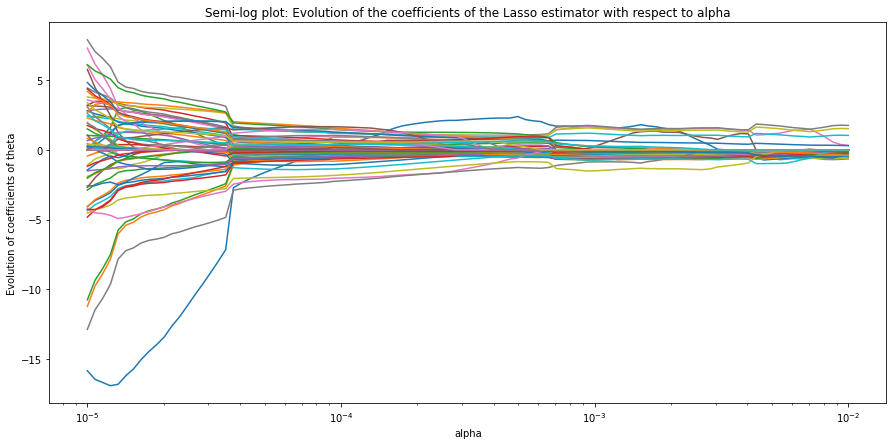

In [87]:
# Plotting the evolution of Lasso estimator
plt.figure(figsize=(15,7))
for i in range(len(L_estimators)):
    plt.semilogx(L_alpha_interval, L_estimators[i])
plt.xlabel("alpha")
plt.ylabel("Evolution of coefficients of theta")
plt.title("Semi-log plot: Evolution of the coefficients of the Lasso estimator with respect to alpha")
plt.show()

### The number of non-nul coefficients for each $\alpha$

In [88]:
# Plotting the number of non-null coefficients for each alpha
count = []
for i in range(L_estimators.shape[1]):
    # indices of non-null coefficients in each theta
    non_nul = [j for j, x in enumerate(L_estimators[:,i]) if abs(x) > 0] 
    count.append(len(non_nul))
   

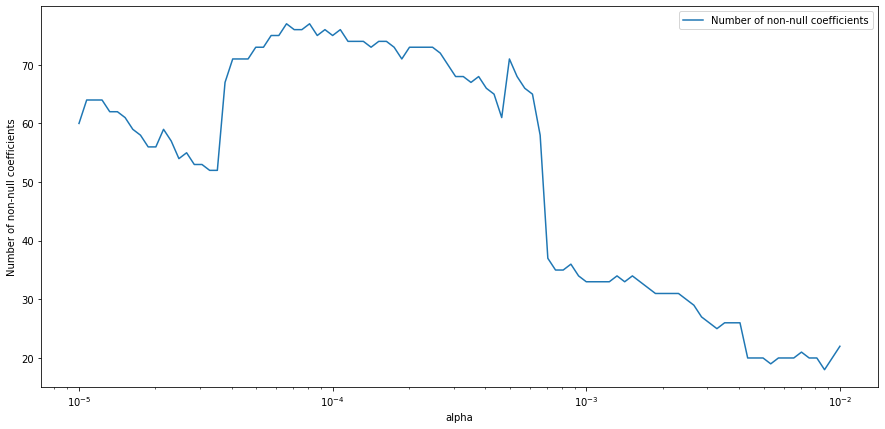

In [89]:
# Plotting  
plt.figure(figsize=(15,7))
plt.semilogx(L_alpha_interval, count, label = 'Number of non-null coefficients')
plt.xlabel('alpha')
plt.ylabel('Number of non-null coefficients')
plt.legend()
plt.show()

### Observation and interpretation
We observe that the number of null coefficients increases with $\alpha$. Which can be explained as follows:
We know that (chapter 5 in the course SD-TSIA204) minimizing (LASSO) with respect to the k-th coordinate is the same as minimizing :
$$ \frac{1}{2}(\langle z_k, \frac{X_k}{\| X_k\|^2} \rangle - \theta_k)^2 + \frac{\alpha}{\| X_k\|^2} |\theta_k| $$ 
Hence, the update is :
$$ \hat{\theta_k} = \eta_{\alpha / \| X_K\|^2} (\langle z_k, \frac{X_k}{\| X_k\|^2} \rangle) $$
Where $\eta_{\lambda}$ is the Soft thresholding function, which is given by:
$$\eta_{\lambda}(x) = 
\begin{cases}
x + \lambda & \text{if } x < - \lambda \\
0 & \text{if } x \in [- \lambda, \lambda] \\
x - \lambda & \text{if } x > \lambda
\end{cases}$$

Therefore, we observe that when $\alpha$ increases, the fraction $ \frac{\alpha}{\| X_K\|^2}$ becomes larger, and then the inner product $ \langle z_k, \frac{X_k}{\| X_k\|^2} \rangle $ is more likely to get in the interval $ [-\frac{\alpha}{\| X_K\|^2}, \frac{\alpha}{\| X_K\|^2} ] $, and in that case $ \hat{\theta}_k = 0$.

### 6 - (c) Computing the Mean Squared Errors for train and test sets and plotting their evolution with $\alpha$

In [90]:
# MSE of training set and test set
L_MSE_train = []
L_MSE_test = []

for i in range(len(L_pred_train)):
    L_MSE_train.append(MSE(y_train_scaled, L_pred_train[i].reshape(-1,1)))
    L_MSE_test.append(MSE(y_test_scaled, L_pred_test[i].reshape(-1,1)))
                     
L_argmin_train = np.argmin(L_MSE_train)
L_argmin_test = np.argmin(L_MSE_test)
L_min_train = min(L_MSE_train)
L_min_test = min(L_MSE_test)

### Evolution of the MSE

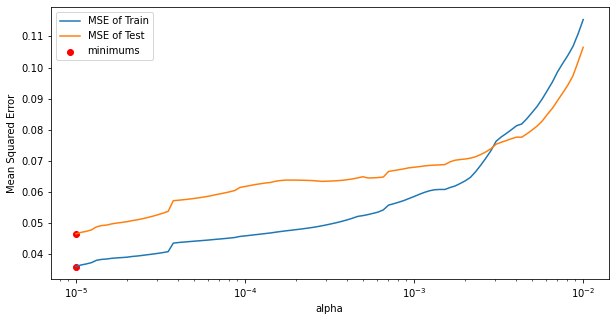

In [91]:
# Plotting the evolution of MSE
plt.figure(figsize = (10,5))
plt.semilogx(L_alpha_interval, L_MSE_train, label = 'MSE of Train')
plt.semilogx(L_alpha_interval, L_MSE_test, label = 'MSE of Test')
plt.scatter(L_alpha_interval[[L_argmin_train, L_argmin_test]], [L_min_train, L_min_test], c='r', label = 'minimums')
plt.xlabel("alpha")
plt.ylabel("Mean Squared Error")
plt.legend()
plt.show()

### Remark:
The values of MSE change with the parameters tol and max_iter in the Lasso model. In fact, with different values of tol and max_iter, we get different results !

### 6 - (d) $R^2$ fot the best performing value of $\alpha$

In [93]:
# The best alpha is the following
L_best_alpha = L_alpha_interval[L_argmin_train]
print("The best performing value of alpha for Lasso is ",L_best_alpha)

# Computing the R2 coefficient using the function that we defined in question 1
lasso = Lasso(alpha = L_best_alpha, tol = 1e-2, max_iter = 500000).fit(X_train_scaled, y_train_scaled)
y_pred5 = lasso.predict(X_test_scaled)
r2 = r2_score(y_test_scaled, y_pred5)

# Adding this new coefficient to the Dataframe
df_coef.loc[4] = ['Lasso',r2]
df_coef

The best performing value of alpha for Lasso is  1e-05


,model,R2
0,OLS,0.960055
1,For_Var_Sel,0.955180
2,Seq_Feat_Sel,0.942024
3,Ridge,0.969223
4,Lasso,0.953578


### Interpretation:
We observe that the Lasso model also describes our data very well, since its determination coefficient is close to 1. 
It is also possible to obtain a more accurate Lasso model if we decrease the parameter tol, but this will take more time to compute the estimator.

## Question 7: Crossvalidation for Elastic Net

### Determining the intervals of $\alpha$ and $\lambda$ used in Elastic Net
We know that the elsatic Net esimator is given by:
$$ \hat{\theta} = \arg \min_{\theta \in \mathbb{R}^p} \frac{1}{2 }\| Y - X\theta \|^2 + \alpha(\lambda \| \theta\|_1 + \frac{1}{2}(1 - \lambda) \| \theta \|^2) $$
Where :
$$ \lambda \in [0, 1] $$ and $$ \alpha \in [10^{-10}, 10^{3}] $$


In [94]:
# Intervals of alpha-Lasso and lambda-Ridge
lambda_cross = [0, 0.1, 0.5, 0.7, 0.9, 0.95, 0.99]
alpha_cross = np.logspace(np.log10(1e-10), np.log10(1e3), num=100)

In [95]:
# Crossvalidation
def crossvalidation(estimator, X, y, scoring, cv):
    l_score = [] # this variable will contain the mean of scoring for each iteration of the crossvalidation
    
    n = X.shape[0]
    length = n//cv
    for i in range(cv):
        # Dividing training set et into training and validation sets
        X_val = X[i*length : (i+1)*length] 
        y_val = y[i*length : (i+1)*length]
        X_train_cv = np.concatenate([X[ : i*length], X[(i+1)*length :]])
        y_train_cv = np.concatenate([y[ : i*length], y[(i+1)*length :]])

        # Compute estimation and its scoring
        model = estimator.fit(X_val, y_val)
        y_pred = model.predict(X_val)
        l_score.append(scoring(y_pred, y_val))
    
    return l_score
 

### Performing crossvalidation for the Elastic Net estimator with scoring MSE

In [ ]:
# List of parameters
params = list(itertools.product(lambda_cross, alpha_cross)) 

# Performing crossvalidation on Elastic Net and determining the best couple of parameters, with scoring MSE
MMSE = [] # here we will store the Mean of MSEs in each step
#warnings.filterwarnings("ignore")
for (lam,alpha) in params:
    estimator = ElasticNet(alpha = alpha, l1_ratio = lam , tol = 5e-1, max_iter = 5000000)
    mmse = np.mean(crossvalidation(estimator, X_train_scaled, y_train_scaled, MSE, 5))
    MMSE.append(mmse)

# Determining the best parameters
i_best = np.argmin(MMSE)
(lambda_best, alpha_best) = params[i_best]
print("The best lambda to use is : ", lambda_best)
print("The best alpha to use is : ", alpha_best)

### Technical remark:
The estimated time to converge for the Elastic Net estimator increase exponentially when we take $tol < 5.10^{—1}$. This is why we chose tol = 5e-1 in order to converge quickly (even if it is not the best choice to do). 

## Question 8: Bootstrapping

### Plotting the regression line and the data for 

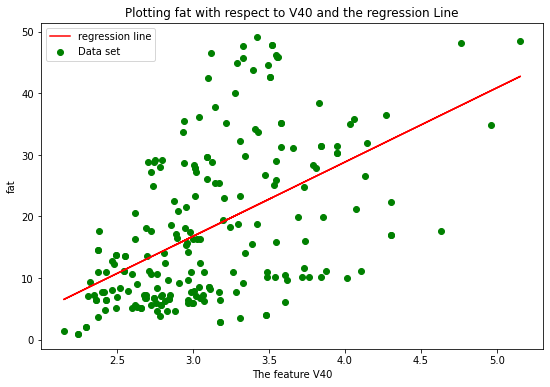

In [110]:
# Selecting the feature 'V40'
X40 = X['V40'].to_numpy().reshape(-1,1)

# Plotting the regression line
model = LinearRegression().fit(X40, y.to_numpy().reshape(-1,1))
y_pred40 = model.predict(X40)

plt.figure(figsize = (9,6))
plt.scatter(X40, y, label = 'Data set', c='g')
plt.plot(X40, y_pred40, label = 'regression line', c = 'r')
plt.xlabel("The feature V40")
plt.ylabel("fat")
plt.title("Plotting fat with respect to V40 and the regression Line")
plt.legend()
plt.show()

### Bootstrapping:
It consists simply on resampling from our dataset with replacement.

### Let us start by defining a function that returns the prediction interval

In [111]:
# Empirical variance
def variance(x): # to compute the estimator of variance
    n = len(x)
    mean_x = np.mean(x)
    return np.sum((x - mean_x)**2)


# Compute the estimator of variance which we denoted (sigma^)**2
def var_estim(x,y,intercept,slope):
    n = len(x)
    var = 0
    var += np.sum((y - (intercept + slope*x))**2)
    return (1/(n-2))*var 

# Prediction interval P(y)
def PI(y,x,intercept,slope,var,alpha_):
    n = len(x)
    
    # boundaries of the confidence interval
    pd0 = 0
    pd1 = 0 
    mean_x = np.mean(x)
    q = t(df=n-2).ppf(1 - alpha_/2)
    pd0 = intercept + slope*y - q*np.sqrt(var*(1 + 1/n +((y-mean_x)**2)/variance(x)))
    pd1 = intercept + slope*y + q*np.sqrt(var*(1 + 1/n +((y-mean_x)**2)/variance(x)))
    return [pd0, pd1]
    

In [113]:
# Creating a bootstrap list
bootstrap = []

# Creating 50 bootstrap samples
X40 = X['V40'].to_numpy()
n_samples = 50
n = len(X40)
for i in range(n_samples):
    sample = np.random.choice(X40, size=n, replace=True)
    bootstrap.append(sample)

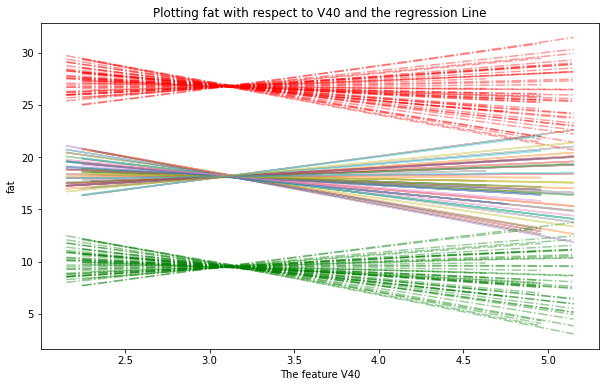

In [114]:
# Fitting OLS and plotting regression line
plt.figure(figsize = (10,6))

for i in range(n_samples):
    x = bootstrap[i]
    b = x.reshape(-1,1)
    model = LinearRegression().fit(b, y.to_numpy().reshape(-1,1))
    y_pred40 = model.predict(b)
    plt.plot(b, y_pred40, alpha = .4)
    
    # Prediction interval of level 95%
    intercept = model.intercept_[0]
    slope = model.coef_[0,0]
    var = var_estim(x, y.to_numpy(), intercept, slope)
    xs = sorted(x)
    pi = list(PI(xs[j],xs,intercept,slope,var,0.5) for j in range(len(x)))
    pi = np.array(pi).T
    plt.plot(xs,pi[0], ls='dashdot', c='g', alpha = .4)
    plt.plot(xs,pi[1], ls='dashdot', c='r', alpha = .4)

plt.xlabel("The feature V40")
plt.ylabel("fat")
plt.title("Plotting fat with respect to V40 and the regression Line")
plt.show()

## Question 9: PCA

### Computing Covariance matrix and SVD of our training set

In [115]:
# Computing the covariance matrix of X_train_scaled and storing it in covM
covX = np.cov(X_train_scaled, rowvar = False)

# SVD of covX
U,s,V = np.linalg.svd(covX)

### 9 - (a) Heatmap

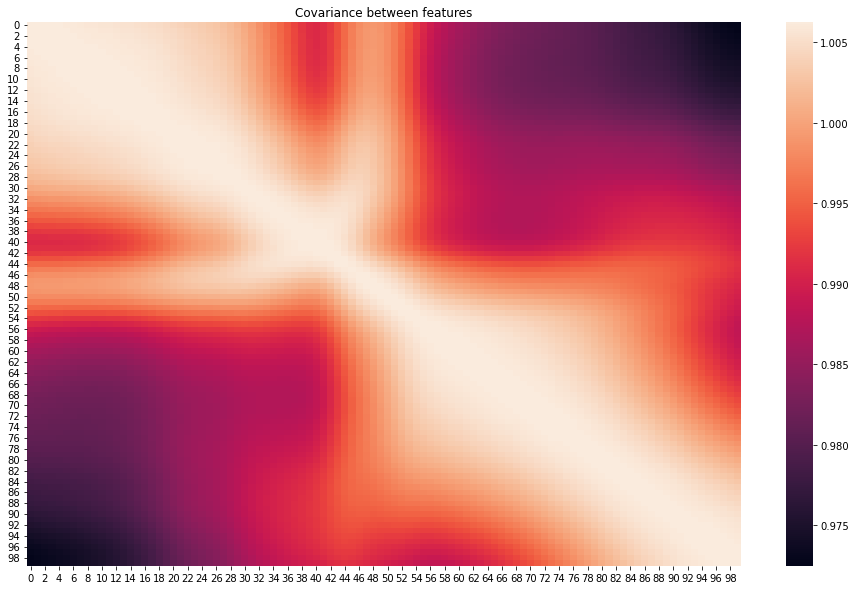

In [116]:
# Set the width and height of the figure
plt.figure(figsize=(16,10))

# Add title
plt.title("Covariance between features")

# Heatmap
sns.heatmap(covX)
plt.show()

### Observation:
We observe from this heatmap that the features are more correlated to the ones that are close to them, for example V1 is so correlated to V2, V3,.., V29, whereas, it is less correlated to V60, V61, ..., V98.

## 9 - (b) PCA

In [117]:
# Let us define a function to compute every PCk given X and U
def PC(X,U,k):
    return (X @ U)[:,k - 1]

# Computing PC1 and PC2
PC1 = PC(X_train_scaled, U, 1)
PC2 = PC(X_train_scaled, U, 2)

## 9 - (c)
The amount of variance explained by the k components is simply given by the ratio of each eigenvalue of the covariance matrix divided by the sum of all eigenvalues. It is a simple task here since the eigenvalues of the covariance matrix are simply the componenets of s. 

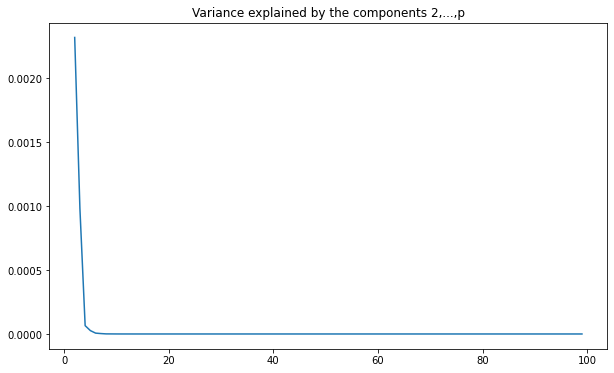

In [118]:
# Plotting the amount of variance explained by the k first components
p = X_train_scaled.shape[1]
total_var = np.sum(s)
variances = list(s[k]/total_var for k in range(2, p))
k = np.arange(2, p)
plt.figure(figsize = (10,6))
plt.plot(k, variances, label='')
plt.title("Variance explained by the components 2,...,p")
plt.show()               

## 9 - (d)

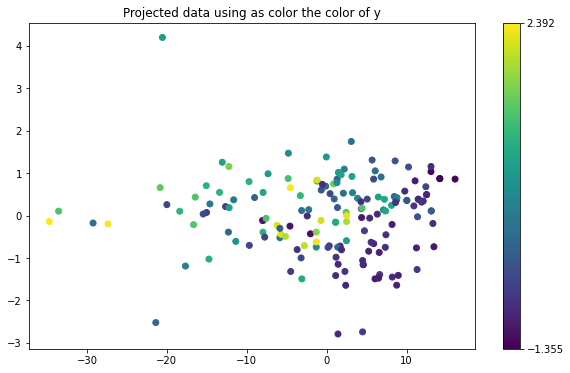

In [120]:
# Plotting the projected data with PC1 and PC2
plt.figure(figsize = (10, 6))
plt.scatter(PC1, PC2, c = y_train_scaled, cmap = plt.cm.get_cmap("viridis"))
cbar = plt.colorbar()
cbar.set_ticks([min(y_train_scaled.T[0]), max(y_train_scaled.T[0])])
plt.title("Projected data using as color the color of y")
plt.show()

## 9 - (e) Running OLS on the projected data using $k \in  \{2,..,p \}$ components:

In [121]:
# Defining a function to compute OLS on k components, and returns the prediction
def PCA_OLS(X_train, U, X_test, y_train, y_test,  k):
    p = X_train.shape[1]
    
    # Choosing evenly spaced integers between 2 and p
    l = np.linspace(1, p - 1, k, dtype=int)
    
    # Creating training set
    X_PCA = (X_train @ U)[:, l]
    
    # Running OLS
    reg = LinearRegression().fit(X_PCA, y_train)
    y_pred = reg.predict((X_test @ U)[:, l])
    return r2_score(y_test, y_pred)


#### Determining the best score, and storing it in our DataFrame

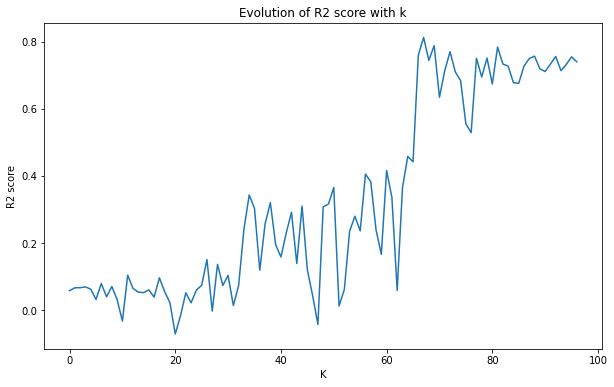

In [122]:
# Let us store r2 values obtained for each k in the following list
l_r2 = []

# Compute r2_scores and then store them in l_r2
for k in range(1, p - 2):
    r2 = PCA_OLS(X_train_scaled, U, X_test_scaled, y_train_scaled, y_test_scaled, k)
    l_r2.append(r2)

# Plotting the evolution of r2 with k
plt.figure(figsize = (10,6))
plt.plot(l_r2)
plt.title("Evolution of R2 score with k")
plt.xlabel("K")
plt.ylabel("R2 score")
plt.show()

### Observation :
The evolution of R2 coefficient has an increasing tendency with k.

### The best value of k

In [123]:
print("The best value for k is ", np.argmax(l_r2))

The best value for k is  67


In [124]:
# Adding the best R2 score to our DataFrame
df_coef.loc[5] = ['PCA', max(l_r2)]

# Comparison of models :

In [228]:
df_coef

,model,R2
0,OLS,0.960055
1,For_Var_Sel,0.955180
2,Seq_Feat_Sel,0.942024
3,Ridge,0.969223
4,Lasso,0.933174
5,PCA,0.812092


We can see that the $R^2$ scores obtained for all these models are pretty much close to 1. Then, we can conclude that these models describe well our dataset. But if we were to give an order to these estimators, we can say that the best model to use here is Ridge model (with the best value of $\alpha$ obtained by minimizing the Mean Squared Error).

The forward variable selection and Sequential Variable Selector gave us good predictions in the test phase, hence, we can say that the features that were not selected are less important to predict the test data.

However, since the $R^2$ values are so close to each other, we cannot really say that Ridge is "better" than Lasso, because to establish an order for estimators, we need to consider more parameters, rather than considering only the $R^2$ score. For example, maybe we would obtain another values of $R^2$, and hence another order, if we take different training and test sets, or if we choose another 'tol' and 'max_iter' parameters in Ridge and Lasso, or if we consider other performance metrics like F1 score, precision, etc, or if we compute the best $\alpha$ parameter using the Mean Absolute Error rather than MSE for Ridge. Therefore, it is hard to establish an order to these models.

We could have also used Forward Variable Selection or Sequential Variable Selection to select the most meaningful features, and then perform a Ridge and Lasso model on these features to obtain new predictions, which could eventually lead to better results. 

# End: Thank you !